In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn

from models import DGI, LogReg
from utils import process
from scipy.sparse import csr_matrix

# from src import functions as f

In [6]:
import networkx as nx
from pathlib import Path

from scipy.sparse import csr_matrix

import os
import pickle
import numpy as np

def load_pickle_file(file_name, dir_path="./data/outputs"):
    file_path = Path(dir_path + "/" + file_name)
    f = open(file_path, 'rb')
    file = pickle.load(f)
    f.close()

    return (file)


def dump_pickle_file(file, file_name, dir_path="./data/outputs"):
    # check directory exists (if not, create it)
    isdir = os.path.isdir(dir_path)

    if isdir == False:
        os.mkdir(dir_path)
        print("Directory created.")
    else:
        pass

    file_path = os.path.join(dir_path, file_name)

    f = open(file_path, 'wb')
    pickle.dump(file, f)

    return ()

In [7]:
import sys
sys.path.append('..')
import src.functions as f

ModuleNotFoundError: No module named 'src'

In [83]:
G2 = load_pickle_file("Graph_er", dir_path="../../data/outputs")
A2 = load_pickle_file("Adjacency_er", dir_path="../../data/outputs")
T2 = load_pickle_file("Transition_er", dir_path="../../data/outputs")

C:\Users\jbryb\AppData\Local\Temp\ipykernel_10544\2770947529.py:13: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  file = pickle.load(f)


In [84]:
nnodes = G2.number_of_nodes()
print("Number of nodes of the graph", G2.number_of_nodes())

Number of nodes of the graph 10631


In [21]:
feature_matrix = np.eye(nnodes, nnodes)

In [7]:
# from torch_geometric.datasets import KarateClub

# dataset = KarateClub()

C:\Users\jbryb\virual_envs_python\pytorch_env\lib\site-packages\torch_geometric\datasets\karate.py:32: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  adj = nx.to_scipy_sparse_matrix(G).tocoo()


In [8]:
data = dataset[0] 

In [9]:
features_karate = data.x
type(features_karate)

torch.Tensor

In [22]:
# Load and process features
features_karate = csr_matrix(feature_matrix).tolil()
features_karate, _ = process.preprocess_features(features_karate)
features_karate = torch.FloatTensor(features_karate[np.newaxis])

In [26]:
# Load and proces grpah & adjacency matrix

import networkx as nx

# G = nx.karate_club_graph()

# A = nx.adjacency_matrix(G)

A = process.normalize_adj(A2 + sp.eye(A2.shape[0]))


sp_A = process.sparse_mx_to_torch_sparse_tensor(A)

# features = torch.FloatTensor(features[np.newaxis])

In [33]:
# training params
batch_size = 1
nb_epochs = 100
patience = 10
lr = 0.01
l2_coef = 1e-5
drop_prob = 0.0
# specify size of encoding vector:
hid_units = 50
sparse = True
nonlinearity = 'prelu' # special name to separate parameters

# Model Karate

In [34]:

nb_nodes = features_karate.shape[1]
ft_size = features_karate.shape[2]
# nb_classes = labels.shape[1]

labels = [] # torch.FloatTensor(labels[np.newaxis])

idx_train = np.arange(len(list(G2.nodes)))
idx_val = np.arange(len(list(G2.nodes)))
idx_test = np.arange(len(list(G2.nodes)))

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [35]:
model = DGI(ft_size, hid_units, nonlinearity)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)

# b_xent applies logits follwoed by cross-entropy loss
b_xent = nn.BCEWithLogitsLoss()
# xent = nn.CrossEntropyLoss()

# cnt_wait counts epochs from the last bes tmodel and implemnts early stopping
cnt_wait = 0
# initial best score for loss
best = 1e9
best_t = 0

loss_history = list()

for epoch in range(nb_epochs):
    model.train()
    optimiser.zero_grad()

    idx = np.random.permutation(nb_nodes)
    # reshuffle features
    shuf_fts = features_karate[:, idx, :]
    # vector of ones, length = number of nodes
    lbl_1 = torch.ones(batch_size, nb_nodes)
    # vector of zeros, length = number of nodes 
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    # length = 2*number of nodes, i.e. 5416
    lbl = torch.cat((lbl_1, lbl_2), 1)

    # the "if" affects onle "sparse" vs "sp_adj"
    # i.e. mask = None, samp_bias1 = None, samp_bias2 = None
    logits = model(features_karate, shuf_fts, sp_A if sparse else adj, sparse, None, None, None) 

    loss = b_xent(logits, lbl)
    loss_history.append(loss.detach().numpy()) # use detach to get rid of the gradient

    print('Loss:', loss)

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), 'best_dgi.pkl')
    else:
        cnt_wait += 1

    if cnt_wait == patience:
        print('Early stopping!')
        break

    loss.backward()
    optimiser.step()

print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_dgi.pkl'))




Loss: tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6925, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6888, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6826, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6757, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6668, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6592, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6509, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6423, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6379, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6280, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6169, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6078, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5915,

<All keys matched successfully>

In [51]:
logits.shape 

torch.Size([1, 21262])

In [48]:
# h contains node representations
# s contains the overall metric representation
h, s = model.embed(features_karate, sp_A, msk = None, sparse = True )

In [60]:
h.shape

torch.Size([1, 10631, 50])

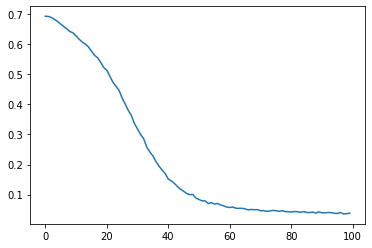

In [37]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

# Ranking of webpages

In [149]:
def calc_cosine_similarity_matrix(X, y):
    '''
    X is a matatrix of embeddings, with nodes in rows (i.e number of rows = number of nodes, 
    number of columns = number of latent dimensions).
    '''
    cosine_similarity = np.dot(X, y)/(np.linalg.norm(X, axis = 1)* np.linalg.norm(y))
    
    return( cosine_similarity )

In [205]:
# def calculate_l2_distance(embeddings, reference_vectors_embeddings):
#     '''
#     For given embeddings, and embeddings of reterence vectors, calulate mean and median distances
#     from each embedding vector to reference vector embeddings.
#     '''
#     mean_distances = [np.linalg.norm(x - reference_vectors_embeddings, axis = 1).mean() for x in embeddings]
#     median_distances = [np.median( np.linalg.norm(x - reference_vectors_embeddings, axis = 1) ) for x in embeddings]

#     return(mean_distances, median_distances)

# def calculate_cosine_distance(G, embeddings, seeds, stats = np.max):
#     '''
#     For any given node in G, calculate similairty to each seed page and return the given summary 
#     statistics of these scores.
#     Returns scores for all nodes in G.
#     '''

#     rankings = list()
#     page_paths = list()

#     for node in G.nodes:

#         rankings_node = list()

#         for seed in seeds:
#             rankings_node.append( calc_cosine_similarity(node, seed) )

#         rankings.append( stats( rankings_node ) )
#         page_paths.append( node )

#     return( rankings, page_paths )

In [146]:
def get_seed_page_index(G, seed_page):
    seed_node_index = np.where(np.array(a) == seed_page)[0]
    seed_node_index = seed_node_index.astype(int)[0]

    print( "Seed node:", list(G2.nodes)[seed_node_index] )
    
    return(seed_node_index)

In [196]:
def get_rankings_dict(G, embeddings, seeds, metric = "cosine"):
    
    rankings = dict()

    rankings["pages"] = list(G.nodes)

    for seed_page in seeds:

        seed_node_index = get_seed_page_index(G, seed_page)
        seed_node_embedding = embeddings[seed_node_index]
        
        if metric == "cosine":
            node_similarities = calc_cosine_similarity_matrix(embeddings, seed_node_embedding)
        else:
            node_similarities = np.linalg.norm(embeddings - seed_node_embedding)

        rankings[seed_page] = node_similarities


    return(rankings)


def get_rankings_df(G, embeddings, seeds, metric = "cosine"):

    emb_dict = get_rankings_dict(G, embeddings, seeds, metric= metric)
        
    emb_df = pd.DataFrame.from_dict(emb_dict)
    
    emb_df.set_index("pages", inplace = True)
    seed_cols = emb_df.columns
    
    emb_df["max"]= emb_df[seed_cols].max(axis = 1)
    emb_df["median"] = emb_df[seed_cols].median(axis = 1)
    emb_df["mean"] = emb_df[seed_cols].mean(axis = 1)
    emb_df["min"]= emb_df[seed_cols].min(axis = 1)
    
    return(emb_df)
    
    

In [185]:
labelled_data_1 = pd.read_csv('../../data/labelled/pages_ranked_with_data_labelled.csv')
labelled_data_1 = labelled_data_1.loc[:,["page path", "label"]]

In [187]:
# THIS IS THE SAME FUNCTION AND IN N2V
def calc_median_difference_n2v(df, labelled_data, standardise = True, page_path = "pagePath"):
    '''df needs to be a result of calling rw.page_freq_path_freq_ranking()
    
    df needs to be ranked from top page to the worst page (i.e. index represents ranking).'''
    df.reset_index(inplace = True, drop = True)
    
    df_labels = df.merge(labelled_data_1, left_on = page_path, right_on = "page path")
    df_labels.reset_index(inplace = True, drop = False)
    df_labels.rename(columns = {"index": "rank"}, inplace = True)

    med_ranking_label1 = df_labels[df_labels["label"] == 1]["rank"].median()
    med_ranking_label0 = df_labels[df_labels["label"] == 0]["rank"].median()
    
    if standardise == True:
        score = (med_ranking_label0 - med_ranking_label1) / ( df_labels[df_labels["label"] == 1]["rank"].std() +
                                                            df_labels[df_labels["label"] == 0]["rank"].std())
    else:
        score = med_ranking_label0 - med_ranking_label1
    
    return( score )

In [200]:
seed_pages_used = [    
    '/find-a-job',
    '/universal-credit',
    '/government/collections/financial-support-for-businesses-during-coronavirus-covid-19']


seed_embeddings = embeddings

In [201]:
df_rankings_cosine = get_rankings_df(G2, embeddings, seed_pages_used, metric = "cosine")
df_rankings_cosine = df_rankings_cosine.sort_values(by = "max", ascending = False).reset_index(drop = False)
df_rankings_cosine.head()


Seed node: /find-a-job
Seed node: /universal-credit
Seed node: /government/collections/financial-support-for-businesses-during-coronavirus-covid-19


,pages,/find-a-job,/universal-credit,/government/collections/financial-support-for-businesses-during-coronavirus-covid-19,max,median,mean,min
0,/universal-credit,0.703397,1.000000,0.772366,1.000000,0.772366,0.825254,0.703397
1,/find-a-job,1.000000,0.703397,0.471634,1.000000,0.703397,0.725011,0.471634
2,/government/collections/financial-support-for-...,0.471634,0.772366,1.000000,1.000000,0.772366,0.748000,0.471634
3,/sign-in-universal-credit,0.701284,0.972882,0.782108,0.972882,0.782108,0.818758,0.701284
4,/benefits-calculators,0.653661,0.968781,0.802347,0.968781,0.802347,0.808263,0.653661


In [202]:
df_rankings_l2 = get_rankings_df(G2, embeddings, seed_pages_used, metric = "l2")
df_rankings_l2 = df_rankings_l2.sort_values(by = "min", ascending = True).reset_index(drop = False)
df_rankings_l2.head()

Seed node: /find-a-job
Seed node: /universal-credit
Seed node: /government/collections/financial-support-for-businesses-during-coronavirus-covid-19


,pages,/find-a-job,/universal-credit,/government/collections/financial-support-for-businesses-during-coronavirus-covid-19,max,median,mean,min
0,/,50.524151,50.073181,21.762175,50.524151,50.073181,40.786503,21.762175
1,/guidance/immigration-rules/immigration-rules-...,50.524151,50.073181,21.762175,50.524151,50.073181,40.786503,21.762175
2,/guidance/data-analyst,50.524151,50.073181,21.762175,50.524151,50.073181,40.786503,21.762175
3,/overseas-domestic-worker-visa/domestic-worker...,50.524151,50.073181,21.762175,50.524151,50.073181,40.786503,21.762175
4,/plug-in-car-van-grants,50.524151,50.073181,21.762175,50.524151,50.073181,40.786503,21.762175


In [203]:
calc_median_difference_n2v(df_rankings_cosine, labelled_data_1, 
                           standardise = True, page_path = "pages")

-0.1654604753910266

In [204]:
calc_median_difference_n2v(df_rankings_l2, labelled_data_1, 
                           standardise = True, page_path = "pages")

-0.01604114333438033